In [ ]:
import math, random, os, gc, gdown, zipfile
import requests as req
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torchvision.transforms as T
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.utils import make_grid
from numba import cuda 
from google.colab import drive

drive.mount('/content/drive')
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

Mounted at /content/drive


In [ ]:
#!mkdir /content/UserPhotos/
#!mkdir /content/UserPhotos/kristy.lani

In [ ]:
#@title CelebA Dataset
class CelebA(Dataset):
    def __init__(self, train = True, subsample = None, norm = True):
        self.path = "/content/datasets/"
        url = "https://drive.google.com/uc?id=1R5EmVSSySBkTQwpTX3MRaAvC5cxlO-Aj"
        self.imgs = []
        self.norm = norm
        self.trans = T.Compose([T.Resize((64, 64))])
        if not os.path.exists(self.path):
            os.makedirs(self.path)
            gdown.download(url, "/content/img_align_celeba.zip")
            with zipfile.ZipFile("/content/img_align_celeba.zip", 'r') as zip:
                zip.extractall(self.path)
        
        for img in os.listdir(self.path + "img_align_celeba/"):
            self.imgs.append(os.path.join(self.path + "img_align_celeba/", img))
        
        if subsample is not None:
            self.imgs = self.imgs[:subsample]
            #self.images = np.random.choice(self.images, size = subsample, replace = False)
        

    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx])
        #img = th.from_numpy(np.load(self.imgs[idx])).permute(2, 0, 1)
        if self.trans is not None:
            img = self.trans(img)
        
        if self.norm:
            img = (np.asarray(img).astype(np.float) / 127.5) - 1.0
            # Normalize between (-1, 1) (Assuming between [0, 1])
            #img = 2 * img - 1
        else:
            #pass
            img = np.asarray(img).astype(np.float) / 255.0
        img = torch.from_numpy(img).permute(2, 0, 1).float()
        return img#, img

    def __len__(self): 
        return len(self.imgs)


In [ ]:
#@title UserPhotos
class UserPhotos(Dataset):
    def __init__(self, username = "", norm = False):
        #user_photos_folder = "/content/drive/My Drive/InstaPhotos/" + username
        #user_photos_folder = "/content/UserPhotos/" + username
        user_photos_folder = "/content/drive/MyDrive/InstaPhotos/"
        self.trans = T.Compose([T.Resize((128, 128)),
                                T.RandomHorizontalFlip(p = 0.5),
                                #T.RandomApply([T.RandomRotation(30)], p = 0.5),
                                #T.RandomApply([T.ColorJitter(brightness = 3)], p = 0.5),
                                #T.RandomApply([T.ColorJitter(contrast = 1)], p = 0.5),
                                #T.RandomApply([T.ColorJitter(saturation = 1)], p = 0.5),
                                #T.RandomApply([T.ColorJitter(hue = 0.2)], p = 0.5)])
        ])
        self.norm = norm
        self.imgs = []
        for img in os.listdir(user_photos_folder):
                self.imgs.append(os.path.join(user_photos_folder, img))

        #self.augment()

    def augment(self):
        transforms = [T.RandomHorizontalFlip(p = 1.0), T.RandomRotation(30), T.RandomAffine(0, translate=(0.4, 0.5)), 
                      T.ColorJitter(brightness = 2), #darker
                      T.ColorJitter(brightness = 4), #brighter
                      T.ColorJitter(contrast = 2),
                      T.ColorJitter(saturation = 2),
                      T.ColorJitter(hue = 0.2)]
        for img in self.imgs:
            img = Image.open(self.imgs[idx])
            for t in transforms:
                save_img(t(img), name = self.imgs[idx] + t.name())
            

    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx])
        if self.trans is not None:
            img = self.trans(img)
        
        if self.norm:
            img = (np.asarray(img).astype(np.float) / 127.5) - 1.0
            # Normalize between (-1, 1) (Assuming between [0, 1])
            #img = 2 * img - 1
        else:
            #pass
            img = np.asarray(img).astype(np.float) / 255.0
        img = torch.from_numpy(img).permute(2, 0, 1).float()
        return img#, img

    def __len__(self): 
        return len(self.imgs)



In [ ]:
#@title VideoDS
class VideoDS(Dataset):
    def __init__(self, norm = False):
        videos_folder = "/content/Videos/"
        self.trans = T.Compose([T.Resize((128, 128)),
                                T.RandomHorizontalFlip(p = 0.5),
                                #T.RandomApply([T.RandomRotation(30)], p = 0.5),
                                #T.RandomApply([T.ColorJitter(brightness = 3)], p = 0.5),
                                #T.RandomApply([T.ColorJitter(contrast = 1)], p = 0.5),
                                #T.RandomApply([T.ColorJitter(saturation = 1)], p = 0.5),
                                #T.RandomApply([T.ColorJitter(hue = 0.2)], p = 0.5)])
        ])
        self.norm = norm
        if  os.path.isdir(videos_folder):
            vids = os.listdir(videos_folder)
            self.frames = []
            for vid_path in vids:
                vid = torchvision.io.VideoReader(vid_path, "video")
                print(vid.get_metadata())
                for frame in vid:
                    self.frames.append(frame['data'])
        print(len(self.frames))

    def __getitem__(self, idx):
        img = self.frames[idx]
        if self.trans is not None:
            img = self.trans(img)
        
        if self.norm:
            img = (np.asarray(img).astype(np.float) / 127.5) - 1.0
            # Normalize between (-1, 1) (Assuming between [0, 1])
            #img = 2 * img - 1
        else:
            #pass
            img = np.asarray(img).astype(np.float) / 255.0
        img = torch.from_numpy(img).permute(2, 0, 1).float()
        return img#, img

    def __len__(self): 
        return len(self.imgs)

In [ ]:
#@title utils

def show_image_grid(imgs):
    plt.figure(figsize = (15, 20))
    plt.axis("off")
    plt.imshow(make_grid(imgs, padding = 2, normalize = True).permute(1, 2, 0))
    #plt.imshow(grid, cmap = 'gray')

In [ ]:
#@title vae.py

def parse_layer_string(s):
    layers = []
    for ss in s.split(","):
        if "x" in ss:
            # Denotes a block repetition operation
            res, num = ss.split("x")
            count = int(num)
            layers += [(int(res), None) for _ in range(count)]
        elif "u" in ss:
            # Denotes a resolution upsampling operation
            res, mixin = [int(a) for a in ss.split("u")]
            layers.append((res, mixin))
        elif "d" in ss:
            # Denotes a resolution downsampling operation
            res, down_rate = [int(a) for a in ss.split("d")]
            layers.append((res, down_rate))
        elif "t" in ss:
            # Denotes a resolution transition operation
            res1, res2 = [int(a) for a in ss.split("t")]
            layers.append(((res1, res2), None))
        else:
            res = int(ss)
            layers.append((res, None))
    return layers


def parse_channel_string(s):
    channel_config = {}
    for ss in s.split(","):
        res, in_channels = ss.split(":")
        channel_config[int(res)] = int(in_channels)
    return channel_config


def get_conv(in_dim, out_dim, kernel_size, stride, padding, zero_bias = True, zero_weights = False, groups = 1):
    c = nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding, groups = groups)
    if zero_bias:
        c.bias.data *= 0.0
    if zero_weights:
        c.weight.data *= 0.0
    return c


def get_3x3(in_dim, out_dim, zero_bias=True, zero_weights=False, groups=1):
    return get_conv(in_dim, out_dim, 3, 1, 1, zero_bias, zero_weights, groups=groups)


def get_1x1(in_dim, out_dim, zero_bias=True, zero_weights=False, groups=1):
    return get_conv(in_dim, out_dim, 1, 1, 0, zero_bias, zero_weights, groups=groups)


class ResBlock(nn.Module):
    def __init__(self, in_width, middle_width, out_width, down_rate = None,
        residual = False, use_3x3 = True, zero_last = False,):

        super().__init__()
        self.down_rate = down_rate
        self.residual = residual
        self.c1 = get_1x1(in_width, middle_width)
        self.c2 = (
            get_3x3(middle_width, middle_width)
            if use_3x3
            else get_1x1(middle_width, middle_width)
        )
        self.c3 = (
            get_3x3(middle_width, middle_width)
            if use_3x3
            else get_1x1(middle_width, middle_width)
        )
        self.c4 = get_1x1(middle_width, out_width, zero_weights=zero_last)

    def forward(self, x):
        xhat = self.c1(F.gelu(x))
        xhat = self.c2(F.gelu(xhat))
        xhat = self.c3(F.gelu(xhat))
        xhat = self.c4(F.gelu(xhat))
        out = x + xhat if self.residual else xhat
        if self.down_rate is not None:
            out = F.avg_pool2d(out, kernel_size=self.down_rate, stride=self.down_rate)
        return out


class Encoder(nn.Module):
    def __init__(self, block_config_str, channel_config_str):
        super().__init__()
        self.in_conv = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False)

        block_config = parse_layer_string(block_config_str)
        channel_config = parse_channel_string(channel_config_str)
        blocks = []
        for _, (res, down_rate) in enumerate(block_config):
            if isinstance(res, tuple):
                # Denotes transition to another resolution
                res1, res2 = res
                blocks.append(
                    nn.Conv2d(channel_config[res1], channel_config[res2], 1, bias=False)
                )
                continue
            in_channel = channel_config[res]
            use_3x3 = res > 1
            blocks.append(
                ResBlock(
                    in_channel,
                    int(0.5 * in_channel),
                    in_channel,
                    down_rate=down_rate,
                    residual=True,
                    use_3x3=use_3x3,
                )
            )
        # TODO: If the training is unstable try using scaling the weights
        self.block_mod = nn.Sequential(*blocks)

        # Latents
        self.mu = nn.Conv2d(channel_config[1], channel_config[1], 1, bias=False)
        self.logvar = nn.Conv2d(channel_config[1], channel_config[1], 1, bias=False)

    def forward(self, input):
        x = self.in_conv(input)
        x = self.block_mod(x)
        return self.mu(x), self.logvar(x)


class Decoder(nn.Module):
    def __init__(self, input_res, block_config_str, channel_config_str):
        super().__init__()
        block_config = parse_layer_string(block_config_str)
        channel_config = parse_channel_string(channel_config_str)
        blocks = []
        for _, (res, up_rate) in enumerate(block_config):
            if isinstance(res, tuple):
                # Denotes transition to another resolution
                res1, res2 = res
                blocks.append(
                    nn.Conv2d(channel_config[res1], channel_config[res2], 1, bias=False)
                )
                continue

            if up_rate is not None:
                blocks.append(nn.Upsample(scale_factor=up_rate, mode="nearest"))
                continue

            in_channel = channel_config[res]
            use_3x3 = res > 1
            blocks.append(
                ResBlock(
                    in_channel,
                    int(0.5 * in_channel),
                    in_channel,
                    down_rate=None,
                    residual=True,
                    use_3x3=use_3x3,
                )
            )
        # TODO: If the training is unstable try using scaling the weights
        self.block_mod = nn.Sequential(*blocks)
        self.last_conv = nn.Conv2d(channel_config[input_res], 3, 3, stride=1, padding=1)

    def forward(self, input):
        x = self.block_mod(input)
        x = self.last_conv(x)
        return torch.sigmoid(x)


# Implementation of the Resnet-VAE using a ResNet backbone as encoder
# and Upsampling blocks as the decoder
class VAE(nn.Module):
    def __init__(self, input_res, enc_block_str, dec_block_str,
        enc_channel_str, dec_channel_str, alpha = 1.0, lr = 1e-4,):

        super().__init__()
        self.input_res = input_res
        self.enc_block_str = enc_block_str
        self.dec_block_str = dec_block_str
        self.enc_channel_str = enc_channel_str
        self.dec_channel_str = dec_channel_str
        self.alpha = alpha
        self.lr = lr

        # Encoder architecture
        self.enc = Encoder(self.enc_block_str, self.enc_channel_str).to(DEVICE)
        # Decoder Architecture
        self.dec = Decoder(self.input_res, self.dec_block_str, self.dec_channel_str).to(DEVICE)

        self.optim = torch.optim.Adam(self.parameters(), lr = self.lr)

    def encode(self, x):
        mu, logvar = self.enc(x)
        return mu, logvar

    def decode(self, z):
        return self.dec(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def compute_kl(self, mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    def forward(self, x):
         # Encoder
        mu, logvar = self.encode(x)

        # Reparameterization Trick
        z = self.reparameterize(mu, logvar)

        # Decoder
        return self.decode(z), mu, logvar
    
    def sigmoid(self, x):
        return 1 / (1 + math.exp(-x))

    def fit(self, train_loader, pth = None):
        best_loss = 100000000000
        if pth is not None:
            last_epoch, best_loss = self.load(pth)
        
        self.train(mode = True)
        for e in range(EPOCHS):
            total_loss = 0.0
            for i, batch in enumerate(train_loader):
                x = batch.to(DEVICE)
                decoder_out, mu, logvar = self(x)
               
                # Compute loss
                mse_loss = nn.MSELoss(reduction = "sum")
                recons_loss = mse_loss(decoder_out, x)
                kl_loss = self.compute_kl(mu, logvar)
                combined_loss = recons_loss + self.alpha * kl_loss
                total_loss += combined_loss.item()
            
                self.optim.zero_grad()
                combined_loss.backward()
                self.optim.step()
            
            print("Epoch", e, "loss: ", round(total_loss / len(train_loader), 3))            
            if best_loss > total_loss:
                best_loss = total_loss
                print("Saving model...")
                torch.save({'epoch': e,
                        'model_state_dict': self.state_dict(),
                        'optimizer_state_dict': self.optim.state_dict(),
                       'loss': total_loss
                    }, "/content/drive/MyDrive/resnetvae.pth")
    
    def sample(self, z_size):
        self.eval()
        with torch.no_grad():
            z = torch.randn(z_size).to(DEVICE)
            # Only sample during inference
            decoder_out = self.decode(z).cpu().detach()
            show_image_grid(decoder_out)

    def regen(self, ds):
        # For generating reconstructions during inference
        self.eval()
        with torch.no_grad():
            x = [ds[i] for i in range(16)]
            x = torch.stack(x, dim = 0).to(DEVICE)
            mu, logvar = self.encode(x)
            z = self.reparameterize(mu, logvar)
            decoder_out = self.decode(z).cpu().detach()
            show_image_grid(decoder_out)

    def load(self, path):
        #loaded_model = th.load("/content/drive/MyDrive/save.pth")
        loaded_model = torch.load(path)
        self.load_state_dict(loaded_model['model_state_dict'])
        self.optim.load_state_dict(loaded_model['optimizer_state_dict'])
        print("Reloading model from epoch", loaded_model['epoch'], ":", round(loaded_model['loss'], 3), "LOSS")
        return loaded_model['epoch'], loaded_model['loss']

In [ ]:
# Training cell
load = False
if load:
    #device = cuda.get_current_device()
    #device.reset()
    torch.cuda.empty_cache()
    ds = None
    vae = None
    train_loader = None
    gc.collect()

# Dataset
#ds = CelebA(subsample = 10000, norm = False)
ds = UserPhotos()


image_size = 128
N = len(ds)
batch_size = 32
batch_size = min(N, batch_size)
LR = 1e-4
EPOCHS = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PIN_MEMORY = True if DEVICE == 'cuda' else False




# Model
# vae = VAE(image_size,
#     # enc_block_str = "64x7,64d2,64t32,32x4,32d2,32t16,16x7,16d2,16t8,8x3,8d2,8t4,4x3,4d4,4t1,1x2",
#     # dec_block_str = "1x1,1u4,1t4,4x2,4u2,4t8,8x3,8u2,8t16,16x7,16u2,16t32,32x8,32u2,32t64,64x10",
#     # enc_channel_str = "64:64,32:128,16:256,8:256,4:256,1:1024",
#     # dec_channel_str = "64:64,32:128,16:256,8:256,4:256,1:1024",
#     enc_block_str = "128x1,128d2,128t64,64x3,64d2,64t32,32x3,32d2,32t16,16x7,16d2,16t8,8x3,8d2,8t4,4x3,4d4,4t1,1x2",
#     enc_channel_str = "128:64,64:64,32:128,16:128,8:256,4:512,1:1024",
#     dec_block_str = "1x1,1u4,1t4,4x2,4u2,4t8,8x2,8u2,8t16,16x6,16u2,16t32,32x2,32u2,32t64,64x2,64u2,64t128,128x1",
#     dec_channel_str = "128:64,64:64,32:128,16:128,8:256,4:512,1:1024",
#     lr = LR, alpha = 1.0)

#vae.lr = 1e-2

# Training
loader_kws = {}
loader_kws["persistent_workers"] = True

# Loader
train_loader = DataLoader(ds, batch_size, num_workers = 2, pin_memory = PIN_MEMORY, shuffle = True, drop_last = True, **loader_kws)
vae.fit(train_loader, pth = "/content/drive/MyDrive/resnetvae.pth")
#vae.fit(train_loader, pth = None)



Reloading model from epoch 97 : 651472.951 LOSS
Epoch 0 loss:  12573.462
Epoch 1 loss:  12529.455
Epoch 2 loss:  12606.58
Epoch 3 loss:  12717.245
Epoch 4 loss:  12700.589
Epoch 5 loss:  12614.636
Epoch 6 loss:  12613.165
Epoch 7 loss:  12615.02
Epoch 8 loss:  12557.318
Epoch 9 loss:  12525.368
Saving model...
Epoch 10 loss:  12503.906
Saving model...
Epoch 11 loss:  12540.91
Epoch 12 loss:  12417.196
Saving model...
Epoch 13 loss:  12467.49
Epoch 14 loss:  12490.515
Epoch 15 loss:  12578.549
Epoch 16 loss:  12513.388
Epoch 17 loss:  12520.004
Epoch 18 loss:  12478.161
Epoch 19 loss:  12449.619
Epoch 20 loss:  12476.687
Epoch 21 loss:  12440.989
Epoch 22 loss:  12491.048
Epoch 23 loss:  12515.458
Epoch 24 loss:  12467.509
Epoch 25 loss:  12451.991
Epoch 26 loss:  12498.278
Epoch 27 loss:  12433.24
Epoch 28 loss:  12455.977
Epoch 29 loss:  12500.919
Epoch 30 loss:  12449.961
Epoch 31 loss:  12398.337
Saving model...
Epoch 32 loss:  12434.437
Epoch 33 loss:  12419.54
Epoch 34 loss:  1248

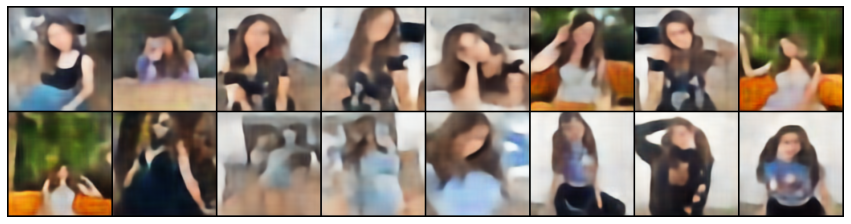

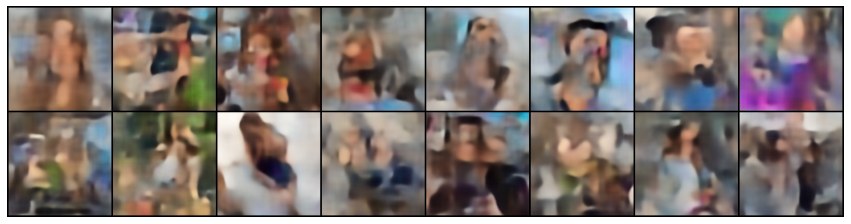

In [ ]:
## Evaluation cell

# Maybe load the best saved model

# Reconstruction
vae.regen(ds)

# Sampling
vae.sample((16, 1024, 1, 1))

In [ ]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [ ]:
!ps -aux|grep python
!kill -9 

root          39  0.0  0.0      0     0 ?        Z    10:30   0:06 [python3] <defunct>
root          40  0.4  0.3 172204 46488 ?        S    10:30   0:56 python3 /usr/local/bin/colab-fileshim.py
root          65  0.0  0.5 201392 67564 ?        Sl   10:30   0:10 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
root         648  0.0  0.0  18380  3100 ?        S    10:47   0:00 bash -c tail -n +0 -F "/root/.config/Google/DriveFS/Logs/drive_fs.txt" | python3 /opt/google/drive/drive-filter.py > "/root/.config/Google/DriveFS/Logs/timeouts.txt" 
root         651  0.0  0.0  31744  9428 ?        S    10:47   0:00 python3 /opt/google/drive/drive-filter.py
root        1409 76.7 23.3 44660040 3109836 ?    Ssl  12:48  46:44 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-2d6bb1d2-300a-4d25-af26-f9ae02176140.json
root        1430  0.3  0.1 129184 17228 ?    